### Numerical Analysis: Project 02
By Pratyush Sudhakar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Iteration 0, Energy: 18385.3394545885, Grad Norm: 189240766407.87546
Iteration 200, Energy: -3.152668876130968e-06, Grad Norm: 2.8858209643920786e-06
Iteration 400, Energy: -3.154335503671299e-06, Grad Norm: 2.8876009092082218e-06
Iteration 600, Energy: -3.156004188494251e-06, Grad Norm: 2.8893832082203957e-06
Iteration 800, Energy: -3.1576749345932943e-06, Grad Norm: 2.8911678662063305e-06
Optimized Positions:
 [[  47.96197354  -43.80057149  -12.07611733]
 [   2.50515808    0.19685181    4.80624588]
 [  -2.01190665    1.30374697   -3.20847543]
 [ -47.78660106   44.70998735   13.91658573]
 [  -0.49441377   98.5058064   131.80249958]
 [   2.21907692  -98.03479087 -130.54573602]]
Optimized Energy: -3.159339376771555e-06


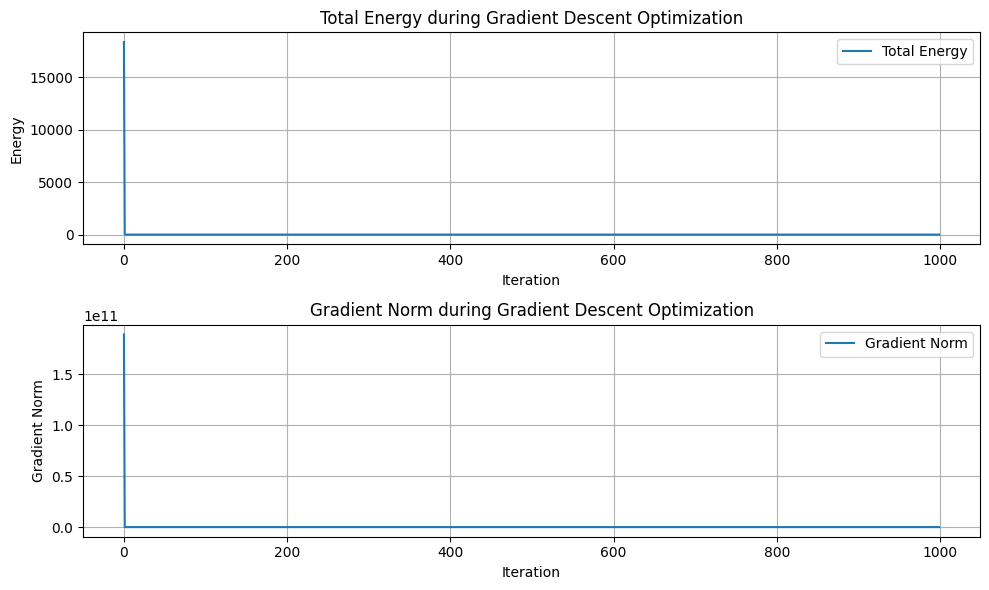

In [17]:
def lennard_jones_potential(r):
    r6 = r**-6
    r12 = r6**2
    return r12 - 2 * r6


def total_energy(positions):
    N = positions.shape[0]
    energy = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            r = np.linalg.norm(positions[i] - positions[j])
            energy += lennard_jones_potential(r)
    return energy


def grad_lennard_jones_potential(r):
    r6 = r**-6
    r12 = r6**2
    return -12 * (r12 - r6) / r


def grad_total_energy(positions):
    N = positions.shape[0]
    grads = np.zeros_like(positions)
    for i in range(N):
        for j in range(i + 1, N):
            r = np.linalg.norm(positions[i] - positions[j])
            grad_potential = grad_lennard_jones_potential(r)
            direction = (positions[i] - positions[j]) / r
            grads[i] += grad_potential * direction
            grads[j] -= grad_potential * direction
    return grads


def line_search(positions, direction, grads, alpha=1.0, beta=0.8, c=1e-4):
    while True:
        new_positions = positions + alpha * direction
        if total_energy(new_positions) <= total_energy(positions) + c * alpha * np.sum(
            grads * direction
        ):
            break
        alpha *= beta
    return alpha


def gradient_descent_optimize(
    initial_positions, learning_rate=0.01, max_iters=1000, tol=1e-6, debug=False
):
    positions = np.copy(initial_positions)
    energies = []
    grad_norms = []
    for i in range(max_iters):
        grads = grad_total_energy(positions)
        direction = -grads
        alpha = line_search(positions, direction, grads)
        positions += alpha * direction
        grad_norm = np.linalg.norm(grads)
        if grad_norm < tol:
            break
        energies.append(total_energy(positions))
        grad_norms.append(grad_norm)
        if i % 200 == 0 and debug:
            print(
                f"Iteration {i}, Energy: {total_energy(positions)}, Grad Norm: {grad_norm}"
            )

    if debug:
        return positions, energies, grad_norms
    return positions


init_pos = np.random.rand(6, 3)
optimized_positions, energies, grad_norms = gradient_descent_optimize(
    init_pos, learning_rate=0.01, max_iters=1000, debug=True
)
print("Optimized Positions:\n", optimized_positions)
print("Optimized Energy:", total_energy(optimized_positions))
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(energies, label="Total Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Total Energy during Gradient Descent Optimization")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(grad_norms, label="Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm during Gradient Descent Optimization")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Iteration 0, Energy: -1.6540392840275535, Grad Norm: 881252319.5957998
Iteration 200, Energy: -5.035574005634448, Grad Norm: 2.5219302878120047
Iteration 400, Energy: -5.05176994458954, Grad Norm: 2.4114731750246
Iteration 600, Energy: -5.0522498589260465, Grad Norm: 2.3882918945239893
Iteration 800, Energy: -5.052299506835339, Grad Norm: 2.3879330208982235
Optimized Positions:
 [[  1.36398241   0.56322779   0.98014864]
 [  0.49368697   0.10042601   0.97289819]
 [-59.87364237 -81.88740313  -8.9697114 ]
 [  0.95558217   0.29183421   0.09136331]
 [  0.702733     0.74823481   1.71810028]
 [ 60.3133189   83.68264644   8.44782671]]
Optimized Energy: -5.052310497700538


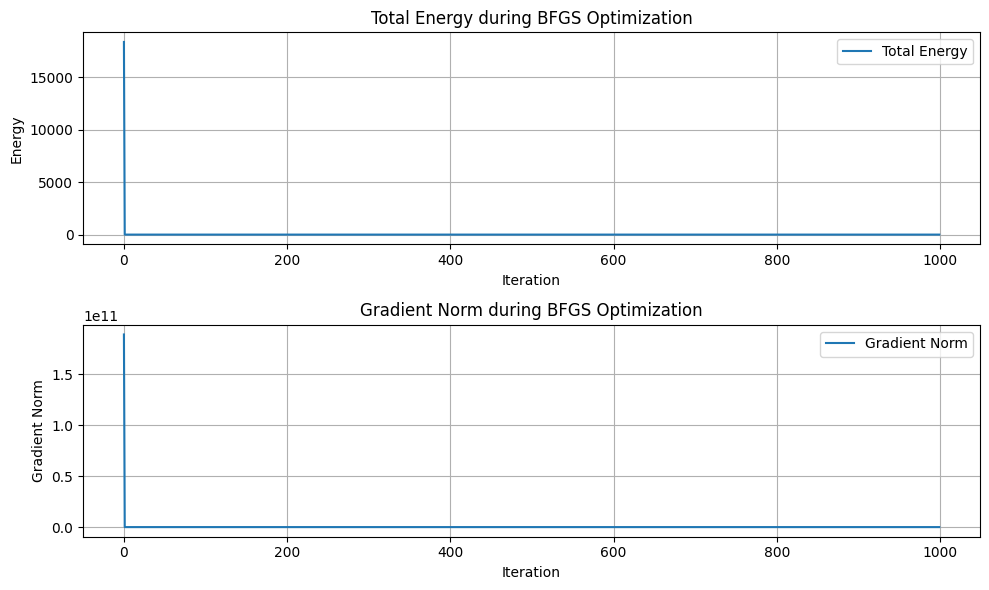

In [18]:
def bfgs_update(H, s, y):
    if np.dot(y, s) == 0:
        return H  # Avoid division by zero
    rho = 1.0 / (y.T @ s)
    I = np.eye(len(s))
    V = I - rho * np.outer(s, y)
    H = V.T @ H @ V + rho * np.outer(s, s)
    return H


# Newton/BFGS optimization
def bfgs_optimize(initial_positions, max_iters=1000, tol=1e-6, debug=False):
    positions = np.copy(initial_positions)
    N = len(positions)
    H = np.eye(N * 3)  # Initial Hessian approximation (identity matrix)

    for i in range(max_iters):
        grads = grad_total_energy(positions).flatten()
        if np.linalg.norm(grads) < tol:
            break
        search_direction = -H @ grads
        search_grads = grads.reshape(N, 3)
        direction = search_direction.reshape(N, 3)
        alpha = line_search(positions, direction, search_grads)
        new_positions = positions + alpha * search_direction.reshape(N, 3)

        s = (new_positions - positions).flatten()
        new_grads = grad_total_energy(new_positions).flatten()
        y = new_grads - grads

        H = bfgs_update(H, s, y)

        positions = new_positions

        if i % 200 == 0 and debug:
            print(
                f"Iteration {i}, Energy: {total_energy(positions)}, Grad Norm: {np.linalg.norm(grads)}"
            )

    if debug:
        return positions, energies, grad_norms
    return positions


# Test the optimization
init_pos = np.random.rand(6, 3)
optimized_positions, energies, grad_norms = bfgs_optimize(initial_positions=init_pos, max_iters=1000, debug=True)
print("Optimized Positions:\n", optimized_positions)
print("Optimized Energy:", total_energy(optimized_positions))
# Plotting the energies
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(energies, label="Total Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Total Energy during BFGS Optimization")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(grad_norms, label="Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm during BFGS Optimization")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
def plot_positions_side_by_side(optimized_positions_gd, optimized_positions_lbfgs):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121, projection="3d")
    ax1.scatter(
        optimized_positions_gd[:, 0],
        optimized_positions_gd[:, 1],
        optimized_positions_gd[:, 2],
        label="Gradient Descent",
    )
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.legend()
    ax1.set_title("Optimized Positions (Gradient Descent)")

    ax2 = fig.add_subplot(122, projection="3d")
    ax2.scatter(
        optimized_positions_lbfgs[:, 0],
        optimized_positions_lbfgs[:, 1],
        optimized_positions_lbfgs[:, 2],
        label="L-BFGS",
    )
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.legend()
    ax2.set_title("Optimized Positions (L-BFGS)")

    plt.show()

def print_positions_side_by_side(
    initial_positions,
    optimized_positions_gd,
    optimized_positions_lbfgs,
    energy_gd,
    energy_lbfgs,
):
    print(
        f"{'Atom':<10}{'Initial Positions':<35}{'Optimized Positions (Gradient Descent)':<45}{'Optimized Positions (L-BFGS)'}"
    )
    print("=" * 125)
    for i in range(len(initial_positions)):
        init_pos = initial_positions[i]
        gd_pos = optimized_positions_gd[i]
        lbfgs_pos = optimized_positions_lbfgs[i]
        print(f"{i:<10}{str(init_pos):<35}{str(gd_pos):<45}{str(lbfgs_pos)}")
    print("=" * 125)
    print(f"{'Total Energy':<10}{'':<35}{energy_gd:<45}{energy_lbfgs}")


def test_optimization(N=3):
    if N != 2:
        initial_positions = np.random.rand(N - 1, 3)
    else:
        initial_positions = np.random.rand(N, 3)
    if N != 2:
        # Fix the first atom at (0, 0, 0)
        initial_positions = np.vstack([[0, 0, 0], initial_positions])

    # Gradient Descent Optimization
    if N == 2:
        optimized_positions_gd = gradient_descent_optimize(
            initial_positions, learning_rate=0.01, max_iters=1000, tol=1e-6, debug=False
        )
    else:
        optimized_positions_gd = gradient_descent_optimize(
            initial_positions[1:], learning_rate=0.01, max_iters=1000, tol=1e-6, debug=False
        )
        optimized_positions_gd = np.vstack([[0, 0, 0], optimized_positions_gd])
    gd_optimal_energy = total_energy(tf.convert_to_tensor(optimized_positions_gd))

    # L-BFGS Optimization
    optimized_positions_lbfgs = bfgs_optimize(
        initial_positions, max_iters=1000, tol=1e-6
    )
    newton_optimal_energy = total_energy(
        tf.convert_to_tensor(optimized_positions_lbfgs)
    )
    print_positions_side_by_side(
        initial_positions,
        optimized_positions_gd,
        optimized_positions_lbfgs,
        gd_optimal_energy,
        newton_optimal_energy,
    )

    # compare the two optimization methods and output which one is better
    comparison_tol = 1e-10
    # if difference is less than comparison_tol, then they are considered equal
    if abs(gd_optimal_energy - newton_optimal_energy) < comparison_tol:
        print("Both optimization methods have the same energy.")
        return "eq"
    elif gd_optimal_energy < newton_optimal_energy:
        print(">> Gradient Descent has lower energy.")
        return "gd"
    else:
        print(">> BFGS has lower energy.")
        return "bfgs"

In [6]:
def run_tests(atom_count=3, test_count=15, final_stats=None):
    if final_stats is None:
        final_stats = {"gd": 0, "bfgs": 0, "eq": 0}
    for i in range(test_count):
        print(f"Test {i + 1} with {atom_count} atoms")
        try:
            optimal_method = test_optimization(N=atom_count)
            if optimal_method == "gd":
                final_stats["gd"] += 1
            elif optimal_method == "bfgs":
                final_stats["bfgs"] += 1
            else:
                final_stats["eq"] += 1
        except Exception as e:
            print(f"Error in test with {atom_count} atoms:", e)
        print("\n")
    return final_stats


def print_stats(final_stats):
    print("=" * 50)
    print(f"{'Optimization Method':<20}{'Count':<10}")
    print("=" * 50)
    for method, count in final_stats.items():
        if method == "gd":
            method = "Gradient Descent"
        elif method == "bfgs":
            method = "Newton/BFGS"
        print(f"{method:<20}{count:<10}")
    print("=" * 50)


def compare_optimization_methods(test_count=15):
    stats = {"gd": 0, "bfgs": 0, "eq": 0}
    for atom_count in range(2, 6):
        atom_stats = {"gd": 0, "bfgs": 0, "eq": 0}
        atom_stats = run_tests(atom_count, test_count, atom_stats)
        for method, count in atom_stats.items():
            stats[method] += count
    print_stats(stats)


compare_optimization_methods(7)

Test 1 with 2 atoms
Atom      Initial Positions                  Optimized Positions (Gradient Descent)       Optimized Positions (L-BFGS)
0         [0.35209487 0.76111129 0.49834275] [ 50.21000101 172.32256403  56.47351371]     [ 50.21000101 172.32256403  56.47351371]
1         [0.20465511 0.25376992 0.33281302] [ -49.65325104 -171.30768282  -55.64235794]  [ -49.65325104 -171.30768282  -55.64235794]
Total Energy                                   -7.191973746653406e-16                       -7.191973746653406e-16
Both optimization methods have the same energy.


Test 2 with 2 atoms
Atom      Initial Positions                  Optimized Positions (Gradient Descent)       Optimized Positions (L-BFGS)
0         [0.09514866 0.26000313 0.7350788 ] [-110.63097253  -64.43926665  -50.41025104]  [-110.63097253  -64.43926665  -50.41025104]
1         [0.37204324 0.42179762 0.86297874] [111.09816443  65.1210674   52.00830857]     [111.09816443  65.1210674   52.00830857]
Total Energy               